# Sequential Bayesian Learning (SBL)
## Authors:  Robert T Lange, Miro Grundei, Sam Gijsen
## Last Update: February 2019

# 0. General Introduction to the project

In this project we investigate the theoretical modelling of mismatch-negativity in the human somatosensory cortex. More specifically, we study a novel roving paradigm which is generated from a structured graphical model. This allows us to define standard and deviant stimuli in stimulus-feature-independent manner. Furthermore, sampling (as opposed to deterministic sequence generation) enables us to control for sequence-dependent cofounding factors.

The following notebook is structured as follows:

- **1. Generation of Trial Sequences based on Graphical Model**
    * We formulate a general Markov model which generates a sequence of trials (0 - low intensity, 0.5 - catch trial, 1 - high intensity)
    * The alternation probability between different observations depends upon the previous observed states as well as the hidden state/regime which is modeled as a Markov Chain.
    * We are able to increase the order of the Markov dependency in the data-generating process. This allows to vary the complexity of the sequence generation.
    
    
- **2. Modeling of different Sequential Bayesian Learning Agents**.
    * The agents process the trial sequence as it comes in. Based on different probabilistic models they update there current posterior estimate about the hidden state that drives the sampling of the observed state. 
    * Based on her current posterior estimate, we can calculate different surprise measures (e.g. Predictive, Bayesian as well as Confidence-Corrected). These surprise measures indicate how well the agent is able to infer the data-generating mechanism and the corresponding hidden states.
    * Going forward we will combine the data-generating paradigm and surprise measures with frequency data obtained from an EEG study. Thereby, we will be able to compare different models with different degrees of complexity of somatosensory adaptation and learning.
    
    
- **3. Model Comparison across Different SBL Agents and Surprise Regressors**
    * Evaluation of theoretical models in explaining the EEG frequency variation. Given the surpise regressors obtained from section 2 we run Bayesian regression models which intend to explain the variability in the EEG signal via the regressors. We infer the model using Variational Inference and compute the log model evidence/negative free energy.
    * In order to do study the development of the fit throughout the interstimulus interval, we obtain a lme per subject-block-electrode-regressor-sample. We do so with the help of auto-differentiation VI and the pymc3 package. Furthermore, we parallelize the computations across the differen sample points.
    * We visualize things in a nice heat plot.
    
- **4. Decoding of Trials/Stimuli Based on EEG Data**
    * Try to predict the character of the trials (high/low intensity) based on EEG signal and/or regressors. Use classifier (e.g. SVM) on raw EEG to achieve this. Try to classify both overall nature as well as alternation over interstimulus interval!

**Loops to Run**
- ~15 Subjects, ~10 Electrodes, 5 blocks
- ~30 Different Models, ~359 Sample Points per event

**TODO**
- [x] HDF5 logging
- [x] Write function that processes the output hdf5 array (average over blocks, sum over subjects)
- [x] Write fct to get data into decoding shape
- [x] Write first decoding model (SVM)
- [x] Start putting things into report
- [x] Put parallelization into py file to run from command line
- [ ] Check if $\tau$ is working
- [ ] Get CS running
- [ ] Get HMM running
- [ ] Figure out why null model is so good ;)
- [ ] Write a general function to get regressors

In [ ]:
!pip install -r requirements.txt --quiet

In [1]:
# Import relevant sampling modules
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import time
import numpy as np

import pymc3 as pm
import theano
import matplotlib.pyplot as plt

from utils.helpers import *
from utils.plotting import *
from utils.glm_models import *

import sampling.seq_gen as sg
import sampling.seq_analysis as sa

# Import relevant SBL modules
import sbl_agents.sbl_cat_dir as sbl_cd
import sbl_agents.sbl_hmm as sbl_hmm

# Set random seed for replicability and define directories
np.random.seed(seed=1234)
results_dir = os.getcwd() + "/results/"
fig_dir = os.getcwd() + "/figures/"
data_dir = os.getcwd() + "/data/"

# 1. Generation of Trial Sequence from Graphical Model

Our sampling paradigm is motivated by the classical roving paradigm. In such a setting a deviant is defined relative to the previous trials.

Depending on whether or not we account for second order Markov dependency also $o_{t-2}$ influences the sampling probabilities. Our generating process can be described by the following graphical model:

<img src="figures/gm_seq_gen.png" alt="drawing" width="750"/>

* Catch: $p(o_t = 0.5) = 0.05$
* Regime switch: $p(s_t \neq s_{t-1}) = 0.01$

Sample a sequence from the Graphical Model and saves it to .mat file
* 1st order Markov sequence of length 800 with following probabilities:
    * Regime 0: $p(o_t = 0|o_{t-1}=0, s_t=0), p(o_t = 1|o_{t-1}=0, s_t=0)$
    * Regime 1: $p(o_t = 0|o_{t-1}=0, s_t=1), p(o_t = 1|o_{t-1}=0, s_t=1)$
```
pythonw seq_gen.py -t 1st_temp -reg_init 0.5 -reg_change 0.01 -catch 0.05 -obs_init 0.5 -obs_change 0.35 0.65 0.65 0.35 -order 1 -v -seq
800
```

* 2nd order Markov sequence of length 800 with following probabilities:
    * Regime 0: $p(o_t = 0|o_{t-1}=0, o_{t-1}=0) = 0.35, p(o_t|o_{t-1}) = 0.65$
    * Regime 1: $p(o_t = 0|o_{t-1}=0) = 0.65, p(o_t|o_{t-1}) = 0.35$
```
pythonw seq_gen.py -t 1st_temp -reg_init 0.5 -reg_change 0.01 -catch 0.05 -obs_init 0.5 -obs_change 0.35 0.65 0.65 0.35 -order 2 -v -seq
800
```

In [ ]:
# Define parameters for sequence sampling
prob_regime_init = np.array([0.5, 0.5])  # Prob. vector for inital regime (hidden state)
prob_regime_change = 0.01  # Prob. of sampling a regime change
prob_obs_init = np.array([0.5, 0.5, 0])  # Prob. vector for inital trial/stimulus (observed state)
prob_obs_change = [0.65, 0.85, 0.15, 0.35, 0.3, 0.75, 0.25, 0.7]  # Prob. matrix for different regimes
prob_catch = 0.02  # Prob. of sampling a catch trial (independent of hidden state)

order = len(prob_obs_change)/4  # Markov order/lag dependency in the sampling scheme
seq_length = 800  # Length of sampled sequence
sample_file = "S1_200"  # Title of file saved
matlab_out = True  # Boolean - store file as .mat - otherwise .pkl file
plot_seq = True  # Booelean - plot the sampled sequence
verbose = True  # Print out the transition prob. specification and empirical statistics of the sampled seq
plot_seqs = False  # Boolean to plot stats for different sequences

In [ ]:
# Create instance of sampling class
gen_temp = sg.seq_gen(order, prob_catch, prob_regime_init, prob_regime_change,
                      prob_obs_init, prob_obs_change, verbose)

In [ ]:
# sequence = gen_temp.sample(seq_length)
# Plot the sampled sequence - when exec from command line
sg.sample_and_save(gen_temp, seq_length, sample_file,
                   matlab_out, plot_seq)

In [ ]:
# Plot the distributions/histograms for different parameter settings
if plot_seqs:
    sa.main(order=1, verbose=False, plot=True, save=False)
    sa.main(order=2, verbose=False, plot=True, save=False)

# 2. Modeling of SBL Agents

In [ ]:
# Define list of all subject-block stimulus files
sample_files = [["sub-01/sub-01_ses-1_run-1", "sub-01/sub-01_ses-1_run-2",
                 "sub-01/sub-01_ses-1_run-3", "sub-01/sub-01_ses-1_run-4",
                 "sub-01/sub-01_ses-1_run-5"],
                ["sub-02/sub-02_ses-1_run-1", "sub-02/sub-02_ses-1_run-2",
                 "sub-02/sub-02_ses-1_run-3", "sub-02/sub-02_ses-1_run-4",
                 "sub-02/sub-02_ses-1_run-5"],
                ["sub-04/sub-04_ses-1_run-1", "sub-04/sub-04_ses-1_run-2",
                 "sub-04/sub-04_ses-1_run-3", "sub-04/sub-04_ses-1_run-4",
                 "sub-04/sub-04_ses-1_run-5"]]

In [ ]:
# Load in sequence and hidden from file
sample, meta = load_obj("data/" + sample_files[0][0] + ".mat")
seq, hidden = sample[:, 2], sample[:, 1]

prob_regime_init = meta["prob_regime_init"]
prob_obs_init = meta["prob_obs_init"]
prob_obs_change = meta["prob_obs_change"]
prob_regime_change = meta["prob_regime_change"]

print("Initial Regime Probability: {}".format(prob_regime_init))
print("Initial Observ Probability: {}".format(prob_obs_init))
print("Observa Change Probability: {}".format(prob_obs_change))
print("Regime  Change Probability: {}".format(prob_regime_change))

In [ ]:
plot_sequence(seq, hidden, 200)

In [ ]:
# General Modeling Settings
model_types = ["SP", "AP", "TP"]
save_results = True
verbose = True

### 2.1. Conjugate Categorical-Dirichlet Model

In [ ]:
tau = 0.

In [ ]:
# Test agents by calculating posterior after 3 timesteps
# and Surprises for t=1,2,3
for model in model_types:
    sbl_cd.test_agent(seq, hidden, tau, model, verbose)

In [ ]:
for model in model_types:
    sbl_cd.main(seq, hidden, tau, model,
                prob_regime_init, prob_obs_init, prob_obs_change,
                prob_regime_change,
                save_results, title="CD_" + model + "_" + sample_file,
                verbose=False)

In [ ]:
SP_CD = load_obj(results_dir + "CD_" + "SP" + "_" + sample_file + ".pkl")
AP_CD = load_obj(results_dir + "CD_" + "AP" + "_" + sample_file + ".pkl")
TP_CD = load_obj(results_dir + "CD_" + "TP" + "_" + sample_file + ".pkl")

In [ ]:
plot_surprise(SP_CD, AP_CD, TP_CD, normalize=False,
              title=r"Categorical-Dirichlet ($\tau = 0$)",
              max_t=200,
              save_fname=fig_dir + "cd_tau_0_wo_norm.png")

In [ ]:
plot_surprise(SP_CD, AP_CD, TP_CD, normalize=True,
              title=r"Categorical-Dirichlet ($\tau = 0$)",
              max_t=200,
              save_fname=fig_dir + "cd_tau_0_norm.png")

In [ ]:
plot_surprise2(SP_CD, preproc="normalize",
               sub_t="Stimulus Probability Model",
               title=r"Categorical-Dirichlet ($\tau = 0$)",
               max_t=200,
               save_fname=fig_dir + "cd_tau_0_compressed.png")

In [ ]:
for model in model_types:
    sbl_cd.main(seq, hidden, 0.14, model,
                prob_regime_init, prob_obs_init, prob_obs_change,
                prob_regime_change,
                save_results, title="CD_" + model + "_" + sample_file + "_tau_1",
                verbose=False)

In [ ]:
SP_CD_tau = load_obj(results_dir + "CD_" + "SP" + "_" + sample_file + "_tau_1" + ".pkl")
AP_CD_tau = load_obj(results_dir + "CD_" + "AP" + "_" + sample_file + "_tau_1" + ".pkl")
TP_CD_tau = load_obj(results_dir + "CD_" + "TP" + "_" + sample_file + "_tau_1" + ".pkl")

In [ ]:
plot_surprise(SP_CD_tau, AP_CD_tau, TP_CD_tau, normalize=False,
              title=r"Categorical-Dirichlet ($\tau = 0.1$)",
              max_t=200, save_fname="example_regressors")

In [ ]:
plot_surprise(SP_CD_tau, AP_CD_tau, TP_CD_tau, normalize=True,
              title=r"Categorical-Dirichlet ($\tau = 0.1$)",
              max_t=200)

Saved figure to /Users/rtl/Dropbox/PHD_ECN/LAB_ROTATION_1_BLANKENBURG/SBL/figures/cd_tau_14_compressed.png


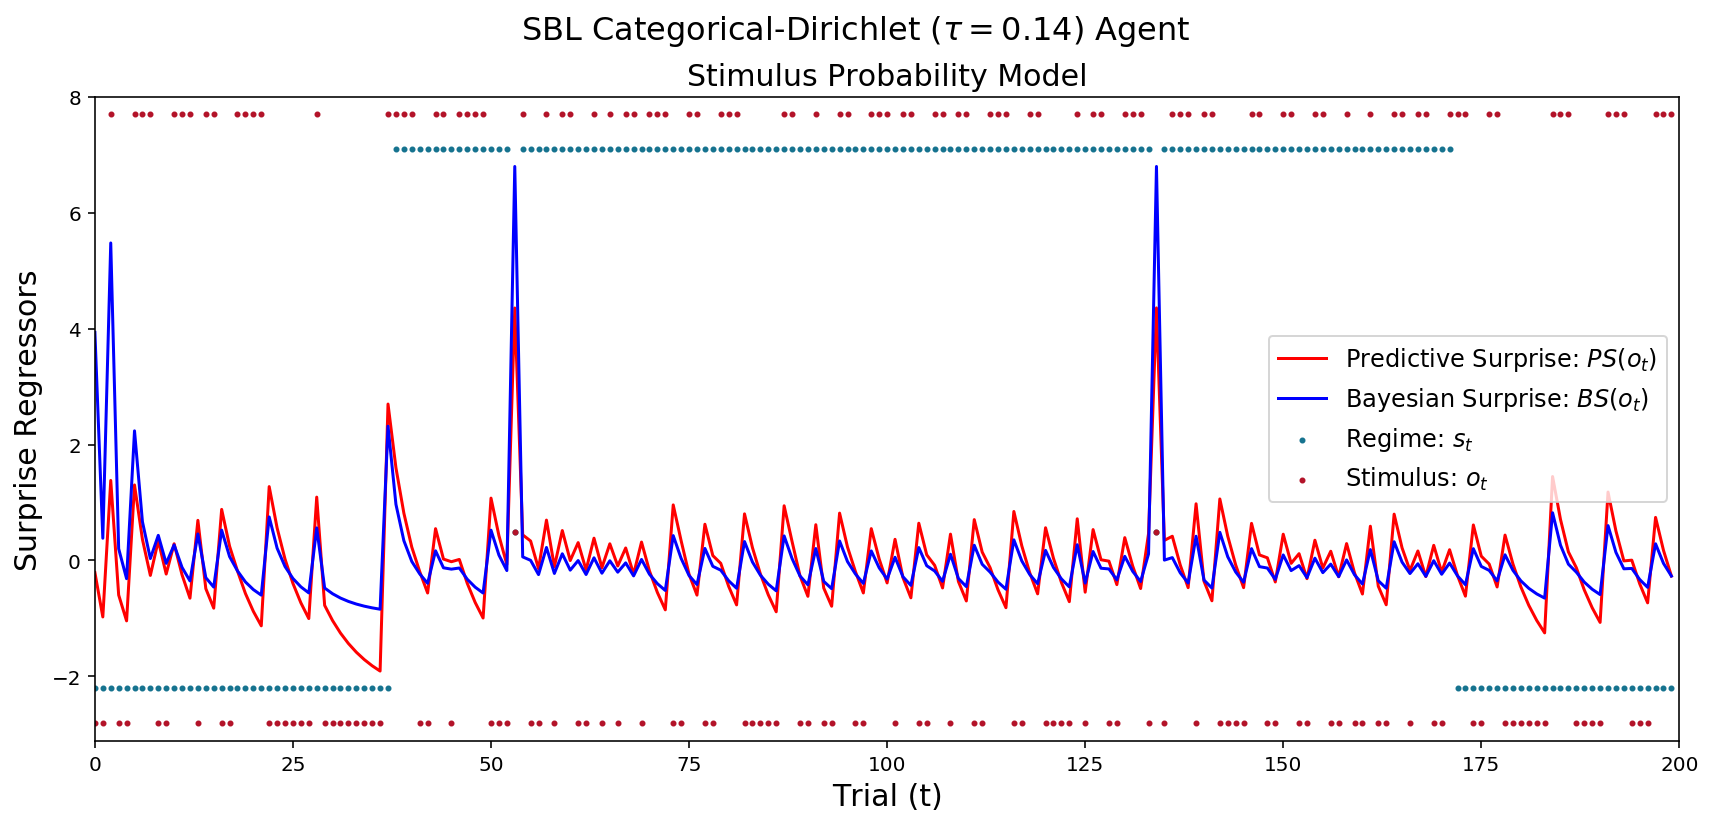

In [8]:
plot_surprise2(SP_CD, preproc="normalize",
               sub_t="Stimulus Probability Model",
               title=r"Categorical-Dirichlet ($\tau = 0.14$)",
               max_t=200,
               save_fname=fig_dir + "cd_tau_14_compressed.png")

### 2.2. Hidden Markov Model

In [ ]:
n_states = 2
model_types = ["SP", "AP"]

In [ ]:
# Test agents by calculating posterior after 3 timesteps
# and Surprises for t=1,2,3
for model in model_types:
    sbl_hmm.test_agent(seq, hidden, n_states, model, verbose)

In [ ]:
for model in model_types:
    sbl_hmm.main(seq, hidden, n_states, model,
                 prob_regime_init, prob_obs_init, prob_obs_change,
                 prob_regime_change,
                 save_results, title="HMM_" + model + "_" + sample_file,
                 verbose=False)

In [ ]:
SP_HMM_2 = load_obj(results_dir + "HMM_" + "SP" + "_" + sample_file + ".pkl")
AP_HMM_2 = load_obj(results_dir + "HMM_" + "AP" + "_" + sample_file + ".pkl")
# TP_HMM = load_obj(results_dir + "HMM_" + "TP" + "_" + sample_file + ".pkl")

In [ ]:
plot_surprise(SP_HMM_2, AP_HMM_2, TP_CD, normalize=False,
              title=r"Categorical-Dirichlet ($\tau = 0.1$)",
              max_t=200)

In [ ]:
plot_surprise2(SP_HMM_2, preproc="normalize",
               sub_t="Stimulus Probability Model",
               title=r"HMM (2 Hidden States)",
               max_t=200,
               save_fname=None)
#fig_dir + "cd_tau_14_compressed.png"

In [ ]:
plot_surprise2(AP_HMM_2, preproc="normalize",
               sub_t="Alternation Probability Model",
               title=r"HMM (2 Hidden States)",
               max_t=200,
               save_fname=None)
#fig_dir + "cd_tau_14_compressed.png"

## 3. Model Comp. across SBL Agents and Surprises

In [ ]:
# Load in EEG Dataset - For first subject
eeg_files = ["sub-01/sub-01_sbl"]
subject_list = range(len(eeg_files))

eeg_data = sio.loadmat("data/" + eeg_files[0] + ".mat")

In [ ]:
electrodes_of_interest = {"FCz": 47, "FC2": 46, "FC4": 45, 
                          "Cz": 48, "C2": 49, "C4": 50,
                          "C6": 51, "CPz": 32, "CP2": 56,
                          "CP4": 55, "CP6": 54}

trial_coding_lookup = {11: "First Regime - Low Intensity",
                       12: "First Regime - High Intensity",
                       21: "Second Regime - Low Intensity",
                       22: "Second Regime - High Intensity",
                       33: "Catch Trial"}

# Select block and electrode for analysis
subject_id = 0
block_id = 0
elec_id = electrodes_of_interest["Cz"]
sampling_rate = 0.3
inter_stim_interval = np.array([-0.05, 0.65])

In [ ]:
# Load stimulus sequence and get regressors ready!
sample, meta = load_obj("data/" + sample_files[subject_id][block_id] + ".mat")
seq, hidden = sample[:, 2], sample[:, 1] 

### 3.1 Run Bayesian GLM/Hierarchical Robust/Bayesian NN Model

In [ ]:
# Preprocessor data to get data that we want to explain by the surprise regressors
# Return an array of shape num_trials x sampling rate
y_elec, y_tw, bad_trials = get_electrode_data(eeg_data, block_id, elec_id,
                                             inter_stim_interval, sampling_rate)

In [ ]:
# Compute Surprise Regressors
PS_SP, BS_SP, CS_SP = sbl_cd.main(stim_seq, hidden_seq, tau=0, model_type="SP")
PS_AP, BS_AP, CS_AP = sbl_cd.main(stim_seq, hidden_seq, tau=0, model_type="AP")
PS_TP, BS_TP, CS_TP = sbl_cd.main(stim_seq, hidden_seq, tau=0, model_type="TP")

regressors = {"PS_SP": PS_SP, "BS_SP": BS_SP, "CS_SP": CS_SP,
              "PS_AP": PS_AP, "BS_AP": BS_AP, "CS_AP": CS_AP,
              "PS_TP": PS_TP, "BS_TP": BS_TP, "CS_TP": CS_TP}

In [ ]:
# Run Bayesian Ridge Regression with Half-Cauchy prior on likelihood sd (robust)
%time lme_null = run_model_estimation(10, y_elec, bad_trials, BS_AP, "Null")
print("LME for 10th Sample - Bayesian Null Model with BS for AP: {}""".format(lme_null[-1]))

In [ ]:
# Run Bayesian Ridge Regression with Half-Cauchy prior on likelihood sd (robust)
%time lme_ols = run_model_estimation(10, y_elec, bad_trials, BS_AP, "OLS")
print("LME for 10th Sample - Bayesian GLM with BS for AP: {}""".format(lme_ols[-1]))

In [ ]:
# Run Bayesian Hierarchical Regression
%time lme_hierarchical = run_model_estimation(10, y_elec, bad_trials, BS_AP, "Hierarchical")
print("LME for 10th Sample - Hierarchical GLM with BS for AP: {}""".format(lme_hierarchical[-1]))

In [ ]:
# Run Bayesian MLP with 10 Hidden Units
%time lme_bayes_nn = run_model_estimation(10, y_elec, bad_trials, BS_AP, "Bayesian-MLP")
print("LME for 10th Sample - Bayesian NN with PS for AP: {}""".format(lme_bayes_nn[-1]))

In [ ]:
plot_free_energy([lme_null, lme_ols, lme_hierarchical, lme_bayes_nn])

### 3.2 Run Modeling in Parallel

In [ ]:
y_elec, y_tw, bad_trials= get_electrode_data(eeg_data, block_id, elec_id,
                                             inter_stim_interval=np.array([0.1, 0.5]),
                                             percent_resolution=0.3)

In [ ]:
# Compute LME for all samples in interval in parallel
# For Fz electrode predictive surprise alternation prob regressor
# Inference via Bayesian Robust Ridge Regression
%time BS_AP_lme = parallelize_over_samples(y_elec, BS_AP, reg_model_type="OLS")

In [ ]:
# Compute LME for all samples in interval in parallel
# For Fz electrode - Null model (simply intercept)
%time null_model_lme = parallelize_over_samples(y_elec, regressor=BS_AP, reg_model_type="Null")

In [ ]:
plot_lme_across_int(y_tw, null_model_lme, BS_AP_lme, "BS-AP")

In [ ]:
# Run analysis for subject 1!
# ! python run_in_parallel.py -s_id 0 -s_rate 0.1 -int_start 0.1 -int_stop 0.5 -v

In [ ]:
# Results of first simulation for three electrodes and one subject
log_fnames = ["subject_1.hdf5"]
num_blocks = 4
elec_names = ["C2", "C4", "Cz"]

regressor_names = ["CD_PS_SP", "CD_BS_SP",
                   "CD_PS_AP", "CD_BS_AP",
                   "CD_PS_TP", "CD_BS_TP"]

In [ ]:
for elec_name in elec_names: 
    y_tw, results_all = process_tbt_logs(results_dir, num_blocks, regressor_names,
                                         elec_name, log_fnames)

    y_labels = []
    heat_data = np.empty((0, np.shape(y_tw)[0]))

    for key, values in results_all.items():
        y_labels.append(key)
        heat_data = np.vstack((heat_data, values))
        
    heatmap_lme(heat_data, y_tw, y_labels, title="Log Model Evidence: {}".format(elec_name))

# 4. Decoding

In [ ]:
# Define electrodes of interest
eoi_list = np.arange(64).tolist()
# Get EEG regressors and Stimulus targets for Decoding
X_all, bad_trials, block_ids, tw = get_decoding_data(eeg_data, 4, eoi_list, inter_stim_interval=np.array([0., 0.5]), percent_resolution=0.3)
stim_all = get_decoding_targets(sample_files, subject_id=0, num_blocks=4)

In [ ]:
# Exclude the bad trials
del_id = np.argwhere(bad_trials == 1)
X_clean = np.delete(X_all, del_id, 0)
block_ids_clean = np.delete(block_ids, del_id, 0)
stim_all_clean = np.delete(stim_all, del_id, 0)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from sklearn.preprocessing import MinMaxScaler

svc = SVC(kernel='linear')
cv = LeaveOneGroupOut()

scores = []

for sample in range(X_all.shape[1]):
    scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_clean[:, sample, :])
    X_all_temp = scaling.transform(X_clean[:, sample, :])

    # Compute the prediction accuracy for the different folds (i.e. blocks)
    cv_scores = cross_val_score(svc, X_all_temp, stim_all_clean,
                                cv=cv, groups=block_ids_clean)

    # Return the corresponding mean prediction accuracy
    scores.append(cv_scores.mean())
    # print("Sample {:.2f}ms - Block-CV Accuracy: {:.2f}".format(tw[sample], scores[-1]))

In [ ]:
plt.plot(tw, scores)
plt.xlabel("Inter-Stimulus Interval")
plt.ylabel("Block-CV Accuracy")

In [ ]:
sample = 10
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_all[:, sample, :])
X_all_temp = scaling.transform(X_all[:, sample, :])
svc.fit(X_all_temp, stim_all)
y_pred = svc.predict(X_all_temp)
coef = svc.coef_

In [ ]:
coef.shape